In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'iyw' # ticker symbol
train = 1 # 1 for train, 0 for pass
days_ahead = 5 # for predicting 1 day ahead
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'aapl':'12/12/1980' # Updated 1/2/21 1D, 5D ahead
               , 'acy': '01/18/1998' # Updated 1/2/21 1D, 5D ahead
               , 'amd': '03/17/1980' # Updated 1/2/21 1D, 5D ahead
               , 'baba': '09/15/2014' # Updated 1/2/21 1D, 5D ahead
               , 'bac': '02/19/1973' # Updated 1/2/21 1D, 5D ahead
               , 'crm': '06/23/2004' # Updated 1/2/21 1D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 1/2/21 1D, 5D ahead
               , 'goog': '08/16/2004' # Updated 1/2/21 1D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 1/2/21 1D, 5D ahead
               , 'idex': '05/23/2007' # Updated 1/2/21 1D, 5D ahead
               , 'intc': '03/16/1980' # Updated 1/2/21 1D, 5D ahead
               , 'iyw': '05/15/2000' # Updated 1/2/21 1D, 5D ahead
               , 'ma': '05/21/2006' # Updated 1/1/21
               , 'msft': '03/10/1986' # Updated 1/1/21
               , 'nio': '09/10/2018' # Updated 1/1/21
               , 'nvda': '01/22/1999' # Updated 1/1/21
               , 'pypl': '07/05/2015' # Updated 1/1/21
               , 'tsla': '06/29/2010' # Updated 1/1/21
               , 'v': '03/16/2008' # Updated 1/1/21
               , 'vbiv': '09/04/2002' # Updated 1/1/21
               , 'vgt': '01/26/2004' # Updated 1/1/21
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-17,84.870003,84.290001,84.709999,84.660004,471800.0,84.660004,0.000590,0.006881,0.006180,0.006178,0.006293,-1
2020-12-18,84.849998,83.970001,84.849998,84.480003,403300.0,84.480003,0.004361,0.010480,-0.002126,0.006711,0.005916,1
2020-12-21,84.709999,82.839996,83.540001,84.669998,329200.0,84.669998,-0.013526,0.022574,0.002249,0.006777,0.005810,-1
2020-12-22,85.839996,84.660004,85.150002,85.449997,357600.0,85.449997,-0.003523,0.013938,0.009212,0.004424,0.004419,-1
2020-12-23,85.540001,84.779999,85.540001,84.820000,222400.0,84.820000,0.008417,0.008964,-0.007373,0.006590,0.001629,1
2020-12-24,85.430000,84.860001,84.910004,85.180000,105900.0,85.180000,-0.003180,0.006717,0.004244,0.006307,0.001241,-1
2020-12-28,85.980003,85.239998,85.959999,85.830002,247000.0,85.830002,0.001512,0.008681,0.007631,0.006511,0.003193,-1
2020-12-29,86.419998,85.180000,86.320000,85.330002,316800.0,85.330002,0.011469,0.014557,-0.005825,0.007697,0.001578,-1
2020-12-30,85.839996,85.019997,85.629997,85.070000,183800.0,85.070000,0.006540,0.009645,-0.003047,0.006519,-0.000874,-1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.71305638 0.71305638 0.71305638]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

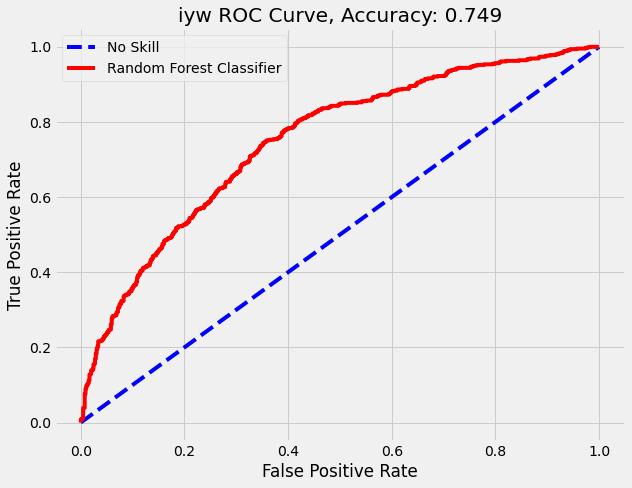

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

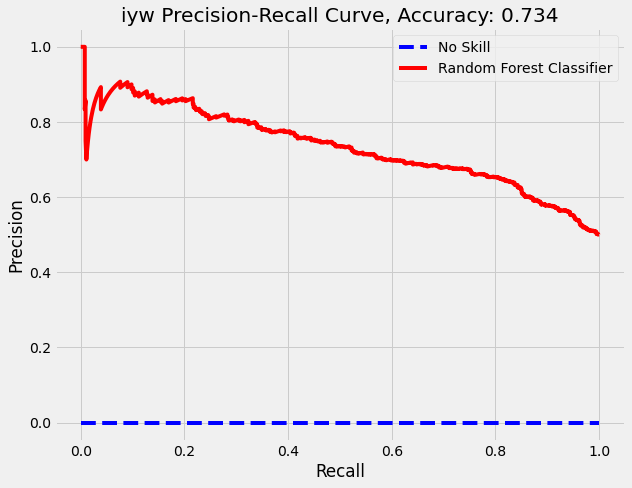

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

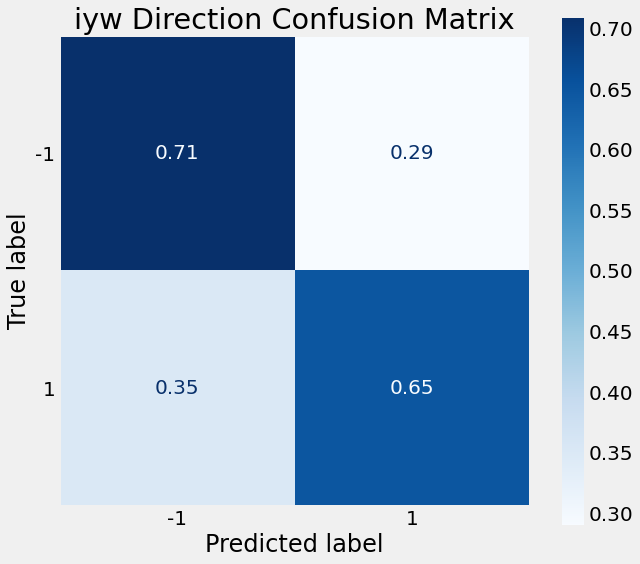

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.6943797634250864'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High              85.320000
Low               84.580002
Open              85.180000
Close             85.080002
Volume        208100.000000
Adj Close         85.080002
oc                 0.001174
hl                 0.008749
adj                0.000118
5stdev_adj         0.005421
5sma_adj           0.000624
direction         -1.000000
Name: 2020-12-31 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc            0.001174
hl            0.008749
5stdev_adj    0.005421
5sma_adj      0.000624
Name: 2020-12-31 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    5183.000000
mean        0.000402
std         0.017333
min        -0.136236
25%        -0.006727
50%         0.001097
75%         0.008030
max         0.177919
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Buy iyw


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-24,85.430000,84.860001,84.910004,85.180000,105900.0,85.180000,-0.003180,0.006717,0.004244,0.006307,0.001241,-1,-1,-0.007631
2020-12-28,85.980003,85.239998,85.959999,85.830002,247000.0,85.830002,0.001512,0.008681,0.007631,0.006511,0.003193,-1,1,-0.005825
2020-12-29,86.419998,85.180000,86.320000,85.330002,316800.0,85.330002,0.011469,0.014557,-0.005825,0.007697,0.001578,-1,1,-0.003047
2020-12-30,85.839996,85.019997,85.629997,85.070000,183800.0,85.070000,0.006540,0.009645,-0.003047,0.006519,-0.000874,-1,1,0.000118
2020-12-31,85.320000,84.580002,85.180000,85.080002,208100.0,85.080002,0.001174,0.008749,0.000118,0.005421,0.000624,-1,1,0.001097


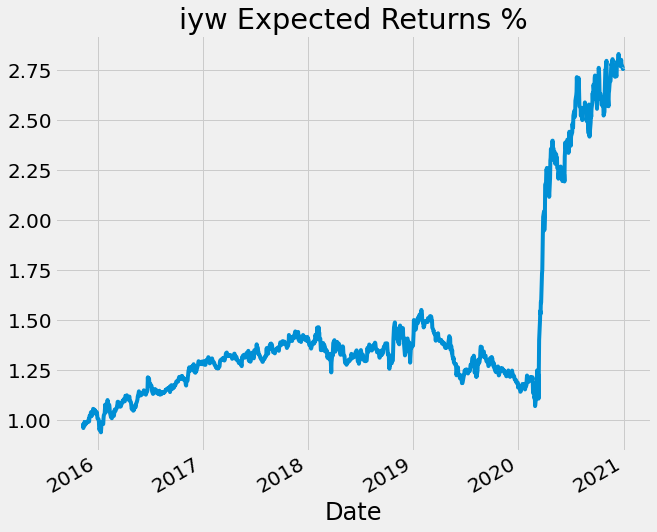

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

3.2086940371851975

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

5.988090389994433

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/